In [1]:
# imports
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances,silhouette_samples,silhouette_score
import matplotlib.pyplot as plt
import pickle

In [2]:
# reading in train data
df = pd.read_csv('data/train_preprocessed_data.csv')
pd.set_option('max_columns', None)
df.drop(columns=['loan_paid'])
df

,requested_amnt,annual_income,debt_to_income_ratio,public_bankruptcies,state,delinquency_last_2yrs,fico_inquired_last_6mths,months_since_last_delinq,revolving_balance,total_revolving_limit,any_tax_liens,loan_paid,missing_vals,income_to_loan_amount_ratio,fico_score,fico_score_range,employment_length,employment_verified,type_of_application,loan_duration,reason_for_loan_credit_card,reason_for_loan_debt_consolidation,reason_for_loan_home_improvement,reason_for_loan_major_purchase,reason_for_loan_other,reason_for_loan_small_business,employment_Manager,employment_Owner,employment_RN,employment_Registered Nurse,employment_Teacher,employment_other,home_ownership_status_ANY,home_ownership_status_MORTGAGE,home_ownership_status_NONE,home_ownership_status_OTHER,home_ownership_status_OWN,home_ownership_status_RENT,zipcode_bad,zipcode_good,zipcode_mid,zipcode_mid_bad,zipcode_mid_good
0,2.001849,2.429058,-0.181194,0,15,0,0,-0.114735,0.271535,1.984340,0,1,1,0.128000,2.577382,4.0,4,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
1,-0.976558,-0.101551,-0.291395,0,3,0,1,-0.171642,-0.442526,-0.481253,0,1,0,0.085714,-1.196633,4.0,10,2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
2,-1.182756,-0.565496,0.271310,0,7,1,0,-1.252866,-0.523397,-0.597631,0,1,0,0.113514,-0.743751,4.0,10,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
3,-0.549844,-0.453025,1.906763,0,22,0,0,-0.114735,0.237305,-0.194368,0,1,1,0.216111,0.463934,4.0,10,2,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0
4,1.085416,0.123392,1.354786,0,27,0,0,2.446060,0.621609,1.943744,0,1,0,0.279070,-1.196633,4.0,10,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967914,-0.747450,-0.087492,0.753072,1,29,1,2,-0.911427,-0.062683,-0.042805,0,1,0,0.112676,-0.743751,4.0,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
967915,-1.205666,-0.551437,-0.475712,0,15,0,0,2.502967,-0.508778,-0.635522,0,1,0,0.105263,-0.139909,4.0,6,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
967916,-0.403788,-0.277288,-0.858001,0,11,0,1,-0.114735,-0.242844,-0.524557,0,1,1,0.191304,1.067776,4.0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
967917,-0.014304,-0.410848,-0.166566,0,43,0,1,-0.114735,-0.025935,-0.318865,0,1,1,0.300000,0.011052,4.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0


In [3]:
# setting up for k-means
x = df.to_numpy()

In [4]:
for col in df.columns:
    df[col] = df[col].astype(np.float64)

In [5]:
x[np.isinf(x)] = 0
print(np.where(np.isinf(x)))

(array([], dtype=int64), array([], dtype=int64))


In [30]:
# silhouette analysis with different k-values
k = range(3, 10)
scores3 = []
for cur_k in k:
    kmeans = KMeans(n_clusters=cur_k)
    kmeans.fit(x)
    print(kmeans.labels_)
    print(type(kmeans.labels_))
    print(np.unique(kmeans.labels_, return_counts=True))
    score = silhouette_score(x, kmeans.labels_, metric='euclidean', sample_size=25000)
    print(score)
    scores3.append(score)

[2 2 2 ... 2 0 0]
<class 'numpy.ndarray'>
(array([0, 1, 2], dtype=int32), array([523238,      2, 444679]))
0.4686826951821267
[0 0 0 ... 0 2 2]
<class 'numpy.ndarray'>
(array([0, 1, 2, 3], dtype=int32), array([444678,      2, 523238,      1]))
0.4654215135958425
[0 0 0 ... 0 3 2]
<class 'numpy.ndarray'>
(array([0, 1, 2, 3, 4], dtype=int32), array([360343,      2, 408177, 199396,      1]))
0.37604126387353143
[0 0 0 ... 0 4 2]
<class 'numpy.ndarray'>
(array([0, 1, 2, 3, 4, 5], dtype=int32), array([360343,      1, 408177,      1, 199396,      1]))
0.37579564792164155
[6 0 0 ... 0 5 2]
<class 'numpy.ndarray'>
(array([0, 1, 2, 3, 4, 5, 6], dtype=int32), array([190243,      1, 377354,      1,      1, 118189, 282130]))
0.34152745961764697
[7 3 3 ... 3 0 2]
<class 'numpy.ndarray'>
(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32), array([115717,      1, 198831, 190242,      1,      1, 211371, 251755]))
0.3174612747462431
[0 6 6 ... 6 4 2]
<class 'numpy.ndarray'>
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]

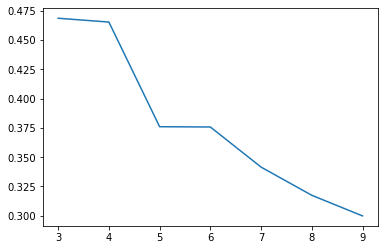

In [31]:
plt.plot(range(3, 10), scores3)

fitted: 50
fitted: 51
fitted: 52
fitted: 53
fitted: 54


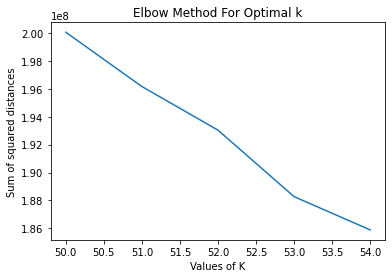

In [85]:
# performing k-means with silhouette analysis
sum_of_squared_distances = []
k_to_try = range(50, 55)
for k in k_to_try:
    kmeans = KMeans(k, random_state=42)
    y_pred = kmeans.fit(x).predict(x)
    print("fitted:", k)
    sum_of_squared_distances.append(kmeans.inertia_)
    b
plt.plot(k_to_try, sum_of_squared_distances)
plt.xlabel('Values of K')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [93]:
# generating items to save
best_k = 20
kmeans = KMeans(best_k, random_state=42)
y_pred = kmeans.fit(x).predict(x)
cluster_count = best_k * [0]
for val in y_pred:
    cluster_count[val] = cluster_count[val] + 1

In [94]:
# saving using pickles
with open('data/cluster_count.pickle', 'wb') as handle:
        pickle.dump(cluster_count, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
with open('models/k_means.pickle', 'wb') as handle:
        pickle.dump(kmeans, handle, protocol=pickle.HIGHEST_PROTOCOL)